In [32]:
import os.path
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

plt.style.use(['fivethirtyeight'])
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

colors = [c['color'] for c in plt.rcParams['axes.prop_cycle']]

In [2]:
# initial computation of database entry counts to achieve desired sizes
key_size = 16
value_sizes = [16, 256, 4096]
db_sizes_gb = [10, 50, 250]
gb = 1000 ** 3
entry_overhead = 4 # approximate


db_specs = pd.DataFrame([dict(value_size=vs, db_size=gb*ds)
                         for vs in value_sizes for ds in db_sizes_gb])
db_specs['entry_size'] = entry_overhead + key_size + db_specs['value_size']
db_specs['entries'] = db_specs['db_size'] / db_specs['entry_size']
db_specs

,value_size,db_size,entry_size,entries
0,16,10000000000,36,2.777778e+08
1,16,50000000000,36,1.388889e+09
2,16,250000000000,36,6.944444e+09
3,256,10000000000,276,3.623188e+07
4,256,50000000000,276,1.811594e+08
5,256,250000000000,276,9.057971e+08
6,4096,10000000000,4116,2.429543e+06
7,4096,50000000000,4116,1.214772e+07
8,4096,250000000000,4116,6.073858e+07


In [3]:
single_gb_file_specs = db_specs[db_specs['db_size'] == 10*gb].set_index('value_size')['entries'] / 10
single_gb_file_specs

value_size
16      2.777778e+07
256     3.623188e+06
4096    2.429543e+05
Name: entries, dtype: float64

In [4]:
figdir = 'figures/disk_key_value_readonly'
!mkdir -p $figdir

In [5]:
!ls ../benchmarks/disk_key_value/readonly/*

../benchmarks/disk_key_value/readonly/c5n.2xlarge_hdd_2020_04_16.jsonl
../benchmarks/disk_key_value/readonly/c5n.2xlarge_ssd_2020_04_16.jsonl
../benchmarks/disk_key_value/readonly/i3.2xlarge_2020_04_16.jsonl
../benchmarks/disk_key_value/readonly/local_2020_04_15.jsonl


In [6]:
duration_seconds = 10

def load_results(pathname, disk_name):
    results = []
    with open(f'../benchmarks/disk_key_value/readonly/{pathname}.jsonl', 'rt') as fp:
        for line in fp:
            spec, counts = json.loads(line)
            spec.update(counts)
            results.append(spec)
    results = pd.DataFrame(results)
    results['disk'] = disk_name
    
    results = results[results['seconds'] == duration_seconds]
    
    split_paths = results['data_path'].map(lambda x: x.split(os.path.sep))

    results['db_size'] = split_paths.map(lambda x: int(x[-2].replace('db', '')))
    results['value_size'] = split_paths.map(lambda x: int(x[-3].replace('vs_', '')))
    results['index'] = results['index_path'].map(os.path.basename)

    results = results.drop(['data_path', 'known_keys_data_path', 'key_set_size', 'index_path', 'seconds'], axis=1)
    return results

results = pd.concat([
    load_results('i3.2xlarge_2020_04_16', 'nvme'),
    load_results('c5n.2xlarge_ssd_2020_04_16', 'ssd'),
    load_results('c5n.2xlarge_hdd_2020_04_16', 'hdd')
])

results.sample(5)

,known_key_get_frac,read_threads,trial_index,get,found,disk,db_size,value_size,index
748,0.1,4,2,1524,149,ssd,50,4096,index1000
657,0.1,1,0,1101,112,hdd,250,4096,index10
804,0.5,4,1,4867,2388,hdd,50,4096,index10
259,0.5,1,7,13824,6868,ssd,50,4096,index10
991,0.9,16,3,8805,7925,hdd,250,4096,index10


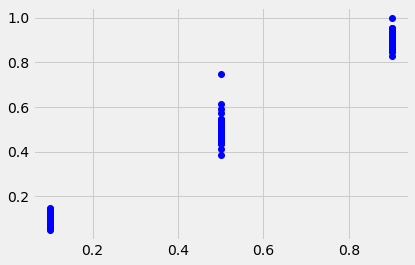

In [7]:
plt.plot(results['known_key_get_frac'], results['found'] / results['get'], 'bo')

In [8]:
x = results.copy()
x['get'] /= (duration_seconds * 1000)
agg = x.groupby(['disk', 'db_size', 'index', 'value_size', 'known_key_get_frac', 'read_threads'])['get'].describe()
agg = agg[['count', 'min', '25%', '50%', '75%', 'max']]
agg.sample(10)

count  \
disk db_size index     value_size known_key_get_frac read_threads          
nvme 10      index100  4096       0.5                64             10.0   
ssd  250     index100  4096       0.1                4              10.0   
     50      index100  4096       0.9                4              10.0   
hdd  10      index100  4096       0.5                64             10.0   
     50      index10   4096       0.9                4              10.0   
nvme 10      index100  4096       0.9                64             10.0   
             index10   4096       0.1                64             10.0   
ssd  50      index10   4096       0.1                1              10.0   
nvme 50      index1000 4096       0.9                1              10.0   
hdd  10      index1000 4096       0.5                1              10.0   

                                                                       min  \
disk db_size index     value_size known_key_get_frac read_threads            
nvme 10      index100  4096       0.5                64            13.7131   
ssd  250     index100  4096       0.1                4              1.1386   
     50      index100  4096       0.9                4              1.2623   
hdd  10      index100  4096       0.5                64             0.4754   
     50      index10   4096       0.9                4              0.3863   
nvme 10      index100  4096       0.9                64            12.5869   
             index10   4096       0.1                64            96.0459   
ssd  50      index10   4096       0.1                1              1.6419   
nvme 50      index1000 4096       0.9                1              0.2736   
hdd  10      index1000 4096       0.5                1              0.0118   

                                                                         25%  \
disk db_size index     value_size known_key_get_frac read_threads              
nvme 10      index100  4096       0.5                64            13.741850   
ssd  250     index100  4096       0.1                4              1.157150   
     50      index100  4096       0.9                4              1.411925   
hdd  10      index100  4096       0.5                64             0.526300   
     50      index10   4096       0.9                4              0.488600   
nvme 10      index100  4096       0.9                64            13.120025   
             index10   4096       0.1                64            98.894975   
ssd  50      index10   4096       0.1                1              1.747500   
nvme 50      index1000 4096       0.9                1              0.282675   
hdd  10      index1000 4096       0.5                1              0.013100   

                                                                         50%  \
disk db_size index     value_size known_key_get_frac read_threads              
nvme 10      index100  4096       0.5                64             13.77565   
ssd  250     index100  4096       0.1                4               1.16990   
     50      index100  4096       0.9                4               1.51520   
hdd  10      index100  4096       0.5                64              0.56835   
     50      index10   4096       0.9                4               0.49865   
nvme 10      index100  4096       0.9                64             13.54305   
             index10   4096       0.1                64            102.13075   
ssd  50      index10   4096       0.1                1               1.91210   
nvme 50      index1000 4096       0.9                1               0.28365   
hdd  10      index1000 4096       0.5                1               0.01385   

                                                                          75%  \
disk db_size index     value_size known_key_get_frac read_threads               
nvme 10      index100  4096       0.5                64             13.850625   
ssd  250     index100  4096       0.1               

In [9]:
agg['50%'].unstack().max(axis=1).unstack()[0.5].unstack()[4096].unstack()

index           index10  index100  index1000
disk db_size                                
hdd  10         3.59965   0.56835    0.19645
     50         0.98645   0.46645    0.10990
     250        0.93950   0.42350    0.09945
nvme 10       103.68735  13.77565    1.43565
     50       100.25510  13.11345    1.38970
     250       89.39995  11.49340    1.16550
ssd  10       113.23915  18.63935    1.67190
     50         3.00330   1.11140    0.16970
     250        2.30125   0.97425    0.14220

In [10]:
disk_colors = dict(zip(sorted(results['disk'].unique()), colors))
index_hatches = dict(zip(sorted(results['index'].unique()), ['/', '\\','-']))

Text(0.5, 1.0, 'Benchmarking of Disk Readonly Key/Value Storage')

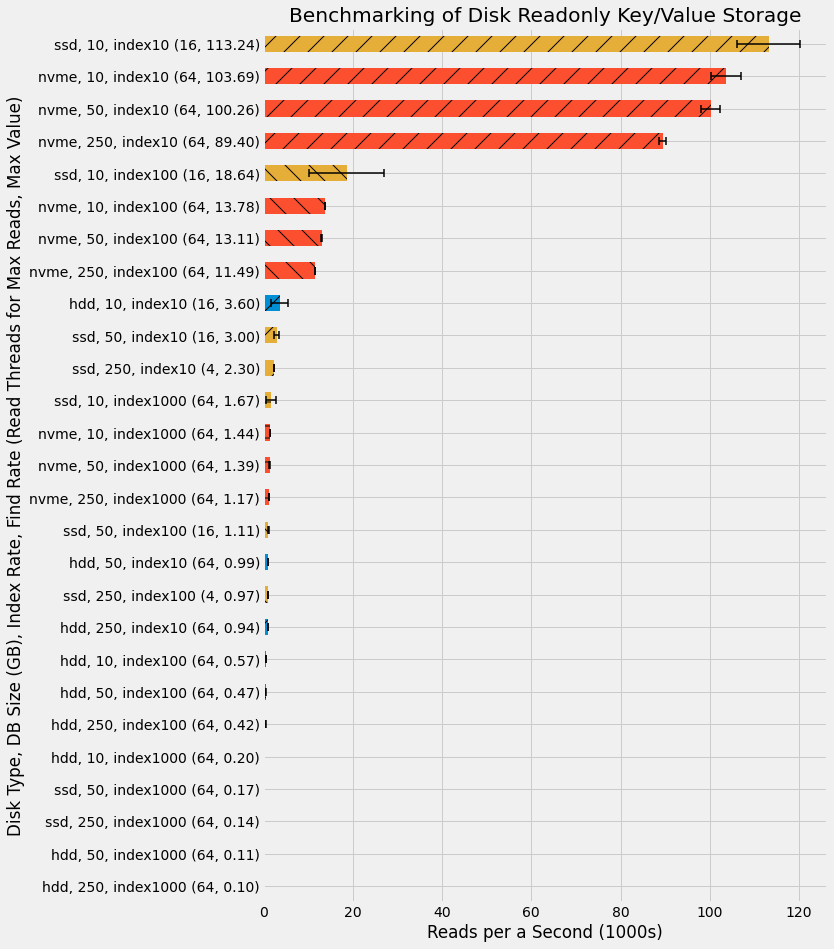

In [65]:
# compute the highest performing thread configuration for each set of parameter
def max_per(df):
    agg_ops = df.set_index('read_threads')
    idxmax = agg_ops['50%'].idxmax()
    opsmax = agg_ops.loc[idxmax]
    opsmax['read_threads'] = idxmax
    return opsmax

x = agg.reset_index()
x = x[x['known_key_get_frac'] == 0.5]
x = x[x['value_size'] == 4096]
x = (x
     .groupby(['disk', 'db_size', 'index'])
     .apply(max_per)
     .sort_values('50%', ascending=True))
iq = x[['25%', '75%']].copy()
iq['25%'] = x['50%'] - iq['25%']
iq['75%'] -= x['50%']
x.plot.barh(figsize=(9, 15), y='50%', xerr=iq.values.T,
            error_kw=dict(ecolor='black', lw=1.5, capsize=4, capthick=1.5),
            color=x.index.to_frame()['disk'].map(disk_colors))
def label(ix):
    r = x.loc[ix]
    disk, db_size, index = ix
    return f'{disk}, {db_size}, {index} ({r["read_threads"]}, {r["50%"]:.2f})'

ax = plt.gca()
ax.get_legend().remove()
ax.set_yticklabels(map(label, x.index))

for c in ax.get_children():
    try:
        c.set_label('')
    except AttributeError:
        pass
bars = [c for c in ax.get_children() if isinstance(c, matplotlib.patches.Rectangle)]
for (disk, db_size, index), bar in zip(x.index, bars):
    bar.set_hatch(index_hatches[index])

plt.ylabel('Disk Type, DB Size (GB), Index Rate, Find Rate (Read Threads for Max Reads, Max Value)')
plt.xlabel('Reads per a Second (1000s)')
plt.title('Benchmarking of Disk Readonly Key/Value Storage')

In [13]:
        iq = x[['25%', '75%']].copy()
        iq['25%'] = x['50%'] - iq['25%']
        iq['75%'] -= x['50%']

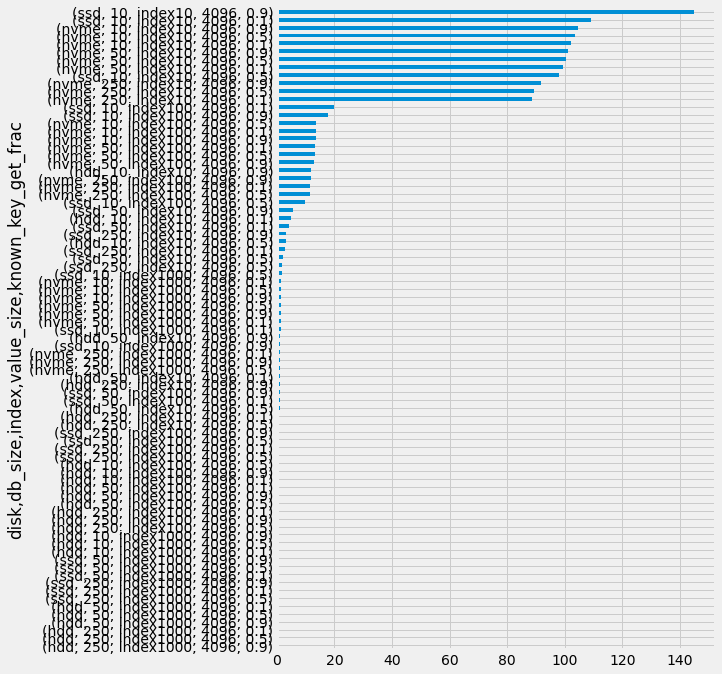

In [14]:
agg['50%'].unstack()[64].sort_values().plot.barh(figsize=(7,11))

In [15]:
((agg['75%'] - agg['25%']) / agg['50%']).describe()

count    324.000000
mean       0.235098
std        0.518057
min        0.003804
25%        0.022740
50%        0.088585
75%        0.246099
max        6.737161
dtype: float64

In [16]:
x = (agg['50%'].reset_index()
 .pivot_table('50%', ['index', 'db_size', 'read_threads'], 'known_key_get_frac'))
(x[0.9] / x[0.1]).sort_values().to_frame()

0
index     db_size read_threads          
index10   10      16            0.885077
index100  10      64            0.936099
                  4             0.954757
index1000 10      64            0.982498
          250     64            0.985346
index100  50      64            0.985994
index1000 50      4             0.990509
index10   50      1             0.991628
index1000 10      1             0.997754
index10   50      4             0.998270
index1000 250     16            1.001130
index100  50      1             1.002539
index1000 50      16            1.002682
index100  50      16            1.003868
          250     64            1.007008
                  16            1.009103
index1000 250     1             1.012462
          10      4             1.013786
index100  50      4             1.014144
index1000 50      1             1.014877
index10   10      1             1.014906
index100  250     4             1.017012
index10   10      4             1.018001
index1000 250     4             1.018841
index10   250     4             1.018905
                  16            1.020060
index1000 50      64            1.024811
index10   50      16            1.029737
                  64            1.031336
          250     64            1.040308
                  1             1.046310
index100  250     1             1.049236
          10      1             1.051270
                  16            1.056328
index1000 10      16            1.064628
index10   10      64            1.208788

In [66]:
x = agg.reset_index()
x = x[x['known_key_get_frac'] == 0.5]
x = x[x['disk'] == 'nvme']
fig = plt.figure(figsize=(7,19))
for i, (disk, x) in enumerate(ax.groupby('disk')):
    ax = fig.add_subplot(3, 1, i+1)
    ax.set_title(disk)
    index_lss = {}
    for (index, x),ls in zip(x.groupby('index'), ['-', '--', ':']):
        x = x.copy()
        x['db_size'] = x['db_size'].map(lambda x: f'DB Size {x} (GB)')
        x = x.groupby(['db_size', 'read_threads'])['50%'].apply(lambda x: x.iloc[0]).unstack().T
        x.plot(ax=ax, lw=3, ms=8, marker='o', ls=ls, color=colors[:3:])
        plt.xticks([1, 4, 16, 64])
        plt.ylabel('Mutli-threading Speed Up')
        plt.xlabel('Concurrent Reading Threads')
        index_lss[index] = ls
    for l in ax.get_lines():
        if l.get_linestyle() != '-': 
            l.set_label(None)
    for index, ls in index_lss.items():
        ax.plot([-5, -5], [1, 1], color='k', ls=ls, label=index)

plt.xlim(0, 70)
plt.legend()

AttributeError: 'AxesSubplot' object has no attribute 'groupby'

<Figure size 504x1368 with 0 Axes>

In [71]:
x

,disk,db_size,index,value_size,known_key_get_frac,count,min,25%,50%,75%,max
read_threads,,,,,,,,,,,
1,nvme,10,index10,4096,0.9,10.0,19.8023,20.175125,20.21350,20.400425,20.4740
4,nvme,10,index10,4096,0.9,10.0,73.8380,74.826425,75.64150,76.222625,76.5692
16,nvme,10,index10,4096,0.9,10.0,97.1253,97.476475,97.83125,98.331475,99.2665
64,nvme,10,index10,4096,0.9,10.0,97.0300,101.269825,104.46680,107.683175,109.5629
1,nvme,50,index10,4096,0.9,10.0,19.2560,19.901700,19.97845,20.058000,20.2539
4,nvme,50,index10,4096,0.9,10.0,71.6117,72.259825,72.70010,73.004275,73.2460
16,nvme,50,index10,4096,0.9,10.0,92.0897,92.835575,93.50415,93.808250,94.8235
64,nvme,50,index10,4096,0.9,10.0,94.2265,97.771500,101.05940,101.854675,104.9678
1,nvme,250,index10,4096,0.9,10.0,11.5042,11.865800,12.42585,12.601450,12.8438


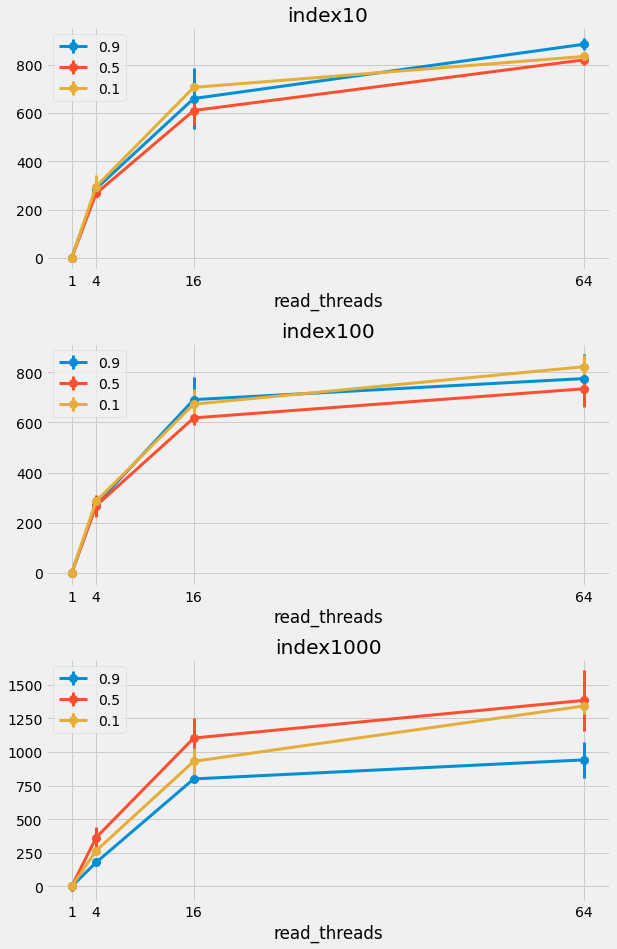

In [74]:
fig = plt.figure(figsize=(9, 15))
fig.subplots_adjust(hspace=0.3)
x = agg.reset_index()
x = x[x['disk'] == 'hdd']
x = x[x['db_size'] == 250]

for i,(index, x) in enumerate(x.groupby('index')):
    ax = fig.add_subplot(3, 1, i+1)
    ax.set_title(index)
    for kkgf, x in list(x.groupby('known_key_get_frac'))[::-1]:
        x = x.set_index('read_threads').copy()
        try:
            t0 = x['50%'].loc[1]
        except KeyError:
            continue
        for c in '25%', '50%', '75%':
            x[c] /= t0
            x[c] -= 1
            x[c] *= 100
        iq = x[['25%', '75%']].copy()
        iq['25%'] = x['50%'] - iq['25%']
        iq['75%'] -= x['50%']

        x.plot(ax=ax, y='50%', yerr=iq.values.T, label=kkgf, marker='o', ms=8, lw=3)
        #ax.set_ylim(-50, 600)
        ax.set_xticks([1, 4, 16, 64])
        ax.legend(loc='upper left')